In [142]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import yaml
import pandas as pd
from itertools import product
import pickle
import uuid
import seaborn as sns
import os
import cddm_data_simulation as cds
import boundary_functions as bf
import kde_training_utilities as kde_utils
import kde_class as kdec
import ckeras_to_numpy as ktnp
import matplotlib.pyplot as plt

# INITIALIZATIONS -------------------------------------------------------------
# INSERT HERE
machine = 'home' # put custom if you want to keep your network_path
model = 'full_ddm'

if machine == 'x7':
    stats = pickle.load(open("/media/data_cifs/afengler/git_repos/nn_likelihoods/kde_stats.pickle", "rb"))
    model_params = stats[model]
    output_folder = model_params['output_folder_x7']
    with open("model_paths_x7.yaml") as tmp_file:
        network_path = yaml.load(tmp_file)[model]
if machine == 'ccv':
    stats = pickle.load(open("/users/afengler/git_repos/nn_likelihoods/kde_stats.pickle", "rb"))
    model_params = stats[model]
    output_folder = model_params['output_folder']
    with open("model_paths.yaml") as tmp_file:
        network_path = yaml.load(tmp_file)[model]
if machine == 'home':
    stats = pickle.load(open("/users/afengler/OneDrive/git_repos/nn_likelihoods/kde_stats.pickle", "rb"))
    model_params = stats[model]
    output_folder = model_params['output_folder']
    with open("model_paths_home.yaml") as tmp_file:
        network_path = yaml.load(tmp_file)[model]

/Users/afengler/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


In [111]:
network_path

'/users/afengler/OneDrive/project_nn_likelihoods/data/kde/angle2/keras_models/dnnregressor_angle2_05_01_20_11_37_10/'

In [143]:
def kde_vs_mlp_likelihoods(ax_titles = [], 
                           title = 'Likelihoods KDE - MLP',
                           network_dir = '',
                           x_labels = [],
                           parameter_matrix = [],
                           cols = 3,
                           model = 'angle',
                           data_signature = '',
                           n_samples = 10,
                           nreps = 10,
                           save = True,
                           show = True,
                           machine = 'home',
                           method = 'mlp'):
    
    # Initialize rows and graph parameters
    rows = int(np.ceil(len(ax_titles) / cols))
    sns.set(style = "white", 
            palette = "muted", 
            color_codes = True,
            font_scale = 2)

    fig, ax = plt.subplots(rows, cols, 
                           figsize = (20, 20), 
                           sharex = False, 
                           sharey = False)
    fig.suptitle(title + ': ' + model.upper(), fontsize = 40)
    sns.despine(right = True)
    
    # Data template
    plot_data = np.zeros((4000, 2))
    plot_data[:, 0] = np.concatenate(([i * 0.01 for i in range(2000, 0, -1)], [i * 0.01 for i in range(1, 2001, 1)]))
    plot_data[:, 1] = np.concatenate((np.repeat(-1, 2000), np.repeat(1, 2000)))
    
    # Load Keras model and initialize batch container
    keras_model = keras.models.load_model(network_dir + 'model_final.h5')
    keras_input_batch = np.zeros((4000, parameter_matrix.shape[1] + 2))
    keras_input_batch[:, parameter_matrix.shape[1]:] = plot_data

    for i in range(len(ax_titles)):
        
        print('Making Plot: ', i)
        
        row_tmp = int(np.floor(i / cols))
        col_tmp = i - (cols * row_tmp)
        
        # Get predictions from keras model
        keras_input_batch[:, :parameter_matrix.shape[1]] = parameter_matrix[i, :]
        ll_out_keras = keras_model.predict(keras_input_batch)
        
        # Get predictions from simulations /kde
        for j in range(nreps):
            if model == 'ddm':
                out = cds.ddm_flexbound(v = parameter_matrix[i, 0],
                                        a = parameter_matrix[i, 1],
                                        w = parameter_matrix[i, 2],
                                        ndt = parameter_matrix[i, 3],
                                        s = 1,
                                        delta_t = 0.001,
                                        max_t = 20, 
                                        n_samples = n_samples,
                                        print_info = False,
                                        boundary_fun = bf.constant,
                                        boundary_multiplicative = True,
                                        boundary_params = {})

            if model == 'full_ddm':
                out = cds.full_ddm(v = parameter_matrix[i, 0],
                                   a = parameter_matrix[i, 1],
                                   w = parameter_matrix[i, 2],
                                   ndt = parameter_matrix[i, 3],
                                   dw = parameter_matrix[i, 4],
                                   sdv = parameter_matrix[i, 5],
                                   dndt = parameter_matrix[i, 6],
                                   s = 1,
                                   delta_t = 0.001,
                                   max_t = 20,
                                   n_samples = n_samples,
                                   print_info = False,
                                   boundary_fun = bf.constant,
                                   boundary_multiplicative = True,
                                   boundary_params = {})

            if model == 'angle' or model == 'angle2':
                out = cds.ddm_flexbound(v = parameter_matrix[i, 0],
                                        a = parameter_matrix[i, 1],
                                        w = parameter_matrix[i, 2],
                                        ndt = parameter_matrix[i, 3],
                                        s = 1,
                                        delta_t = 0.001, 
                                        max_t = 20,
                                        n_samples = n_samples,
                                        print_info = False,
                                        boundary_fun = bf.angle,
                                        boundary_multiplicative = False,
                                        boundary_params = {'theta': parameter_matrix[i, 4]})

            if model == 'weibull_cdf':
                out = cds.ddm_flexbound(v = parameter_matrix[i, 0],
                                        a = parameter_matrix[i, 1],
                                        w = parameter_matrix[i, 2],
                                        ndt = parameter_matrix[i, 3],
                                        s = 1,
                                        delta_t = 0.001, 
                                        max_t = 20,
                                        n_samples = n_samples,
                                        print_info = False,
                                        boundary_fun = bf.weibull_cdf,
                                        boundary_multiplicative = True,
                                        boundary_params = {'alpha': parameter_matrix[i, 4],
                                                           'beta': parameter_matrix[i, 5]})
            if model == 'levy':
                out = cds.levy_flexbound(v = parameter_matrix[i, 0],
                                         a = parameter_matrix[i, 1],
                                         w = parameter_matrix[i, 2],
                                         alpha_diff = parameter_matrix[i, 3],
                                         ndt = parameter_matrix[i, 4],
                                         s = 1,
                                         delta_t = 0.001,
                                         max_t = 20,
                                         n_samples = n_samples,
                                         print_info = False,
                                         boundary_fun = bf.constant,
                                         boundary_multiplicative = True, 
                                         boundary_params = {})

            if model == 'ornstein':
                out = cds.ornstein_uhlenbeck(v = parameter_matrix[i, 0],
                                             a = parameter_matrix[i, 1],
                                             w = parameter_matrix[i, 2],
                                             g = parameter_matrix[i, 3],
                                             ndt = parameter_matrix[i, 4],
                                             s = 1,
                                             delta_t = 0.001, 
                                             max_t = 20,
                                             n_samples = n_samples,
                                             print_info = False,
                                             boundary_fun = bf.constant,
                                             boundary_multiplicative = True,
                                             boundary_params = {})      
            
            mykde = kdec.logkde((out[0], out[1], out[2]))
            ll_out_kde = mykde.kde_eval((plot_data[:, 0], plot_data[:, 1]))

            # Plot kde predictions
            if j == 0:
                sns.lineplot(plot_data[:, 0] * plot_data[:, 1], 
                             np.exp(ll_out_kde),
                             color = 'black',
                             alpha = 0.5,
                             label = 'KDE',
                             ax = ax[row_tmp, col_tmp])
            else:
                sns.lineplot(plot_data[:, 0] * plot_data[:, 1], 
                             np.exp(ll_out_kde),
                             color = 'black',
                             alpha = 0.5,
                             ax = ax[row_tmp, col_tmp])
        
        # Plot keras predictions
        sns.lineplot(plot_data[:, 0] * plot_data[:, 1], 
                     np.exp(ll_out_keras[:, 0]),
                     color = 'green',
                     label = 'MLP',
                     alpha = 1,
                     ax = ax[row_tmp, col_tmp])
        
        # Legend adjustments
        if row_tmp == 0 and col_tmp == 0:
            ax[row_tmp, col_tmp].legend(loc = 'upper left', fancybox = True, shadow = True)
        else: 
            ax[row_tmp, col_tmp].legend().set_visible(False)
        
        
        if row_tmp == rows:
            ax[row_tmp, col_tmp].set_xlabel('rt', 
                                            fontsize = 24);
        
        if col_tmp == 0:
            ax[row_tmp, col_tmp].set_ylabel('likelihood', 
                                            fontsize = 24);
        
        
        ax[row_tmp, col_tmp].set_title(ax_titles[i],
                                       fontsize = 24)
        ax[row_tmp, col_tmp].tick_params(axis = 'y', size = 24)
        ax[row_tmp, col_tmp].tick_params(axis = 'x', size = 24)
        
    for i in range(len(ax_titles), rows * cols, 1):
        row_tmp = int(np.floor(i / cols))
        col_tmp = i - (cols * row_tmp)
        ax[row_tmp, col_tmp].axis('off')

    if save == True:
        if machine == 'home':
            fig_dir = "/users/afengler/OneDrive/git_repos/nn_likelihoods/figures/mlp_performance/"
            if not os.path.isdir(fig_dir):
                os.mkdir(fig_dir)
                
        figure_name = 'mlp_vs_kde_likelihood_'
        plt.savefig(fig_dir + '/' + figure_name + model + '.png', dpi = 150)
    
    if show:
        return plt.show()

In [144]:
# Load training data
training_file_folder = '/users/afengler/OneDrive/project_nn_likelihoods/data/kde/' + model + '/training_data_binned_0_nbins_0_n_20000/'
training_files = os.listdir(training_file_folder)
train_dat = pickle.load(open(training_file_folder + training_files[0], 'rb'))
train_dat = train_dat[train_dat[:, -3] >= 0, :]

In [145]:
# Preprocess
train_dat[:, -1] = np.maximum(train_dat[:, -1], np.log(1e-7))

In [146]:
# Predict Likelihoods
keras_model = keras.models.load_model(network_path + 'model_final.h5')
prediction = keras_model.predict(train_dat[:, :-1], 
                                 batch_size = 100)
prediction = prediction[:, 0]
prediction = np.maximum(prediction, np.log(1e-7))
prediction_error = (prediction - train_dat[:, -1])

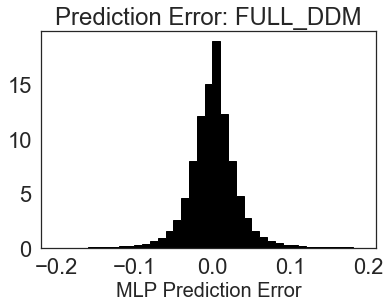

In [147]:
# Distribution of Prediction Errors
plt.hist(prediction_error, 
         bins = np.arange(-0.2, 0.2, 0.01), 
         density = True,
         histtype = 'step',
         color = 'black',
         fill = 'black')
plt.xlabel('MLP Prediction Error', size = 20)
plt.title('Prediction Error: ' + model.upper(), size = 24)
plt.savefig('/Users/afengler/OneDrive/git_repos/nn_likelihoods/figures/mlp_performance/prediction_error_distribution_' + model + '.png', 
            dpi = 150, bbox_inches = 'tight')
plt.show()

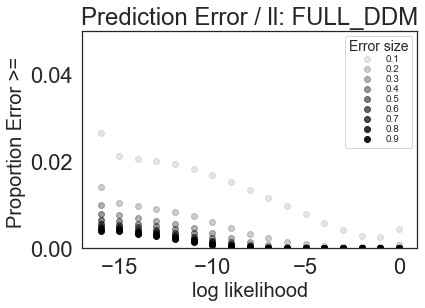

In [148]:
# Graph showing number of cases where prediction error is larger than 1, with loglikelihood of prediction on the x axis
cnt = {}
for err in np.arange(0.1, 1, 0.1):
    cnts[int(err * 10)] = []
    for i in range(17):
        cnts[int(err * 10)].append(np.sum(np.asarray(prediction_error > err) * np.asarray(prediction > - i)) /  np.sum(prediction > - i))
    plt.scatter(-np.arange(0, 17, 1), cnts[int(err * 10)], color = 'black', alpha = err, label = str(round(err, 1)))
    
plt.xlabel('log likelihood', size = 20)
plt.ylabel('Proportion Error >= ', size = 20)
plt.title('Prediction Error / ll: ' + model.upper(), size = 24)
plt.ylim((0, 0.05))
plt.legend(title = 'Error size', title_fontsize = 14, labelspacing = 0.1, fontsize = 10)

plt.savefig('/Users/afengler/OneDrive/git_repos/nn_likelihoods/figures/mlp_performance/prediction_error_vs_likelihood_' + model + '.png', 
            dpi = 150, bbox_inches = 'tight')
plt.show()

In [139]:
n_graphs = 9
param_bounds = np.array(model_params['param_bounds_sampler'] + model_params['boundary_param_bounds_sampler'])
n_params = param_bounds.shape[0]

parameter_matrix = np.random.uniform(low = param_bounds[:, 0],
                                     high = param_bounds[:, 1],
                                     size = (n_graphs, n_params))

Making Plot:  0
Making Plot:  1
Making Plot:  2
Making Plot:  3
Making Plot:  4
Making Plot:  5
Making Plot:  6
Making Plot:  7
Making Plot:  8


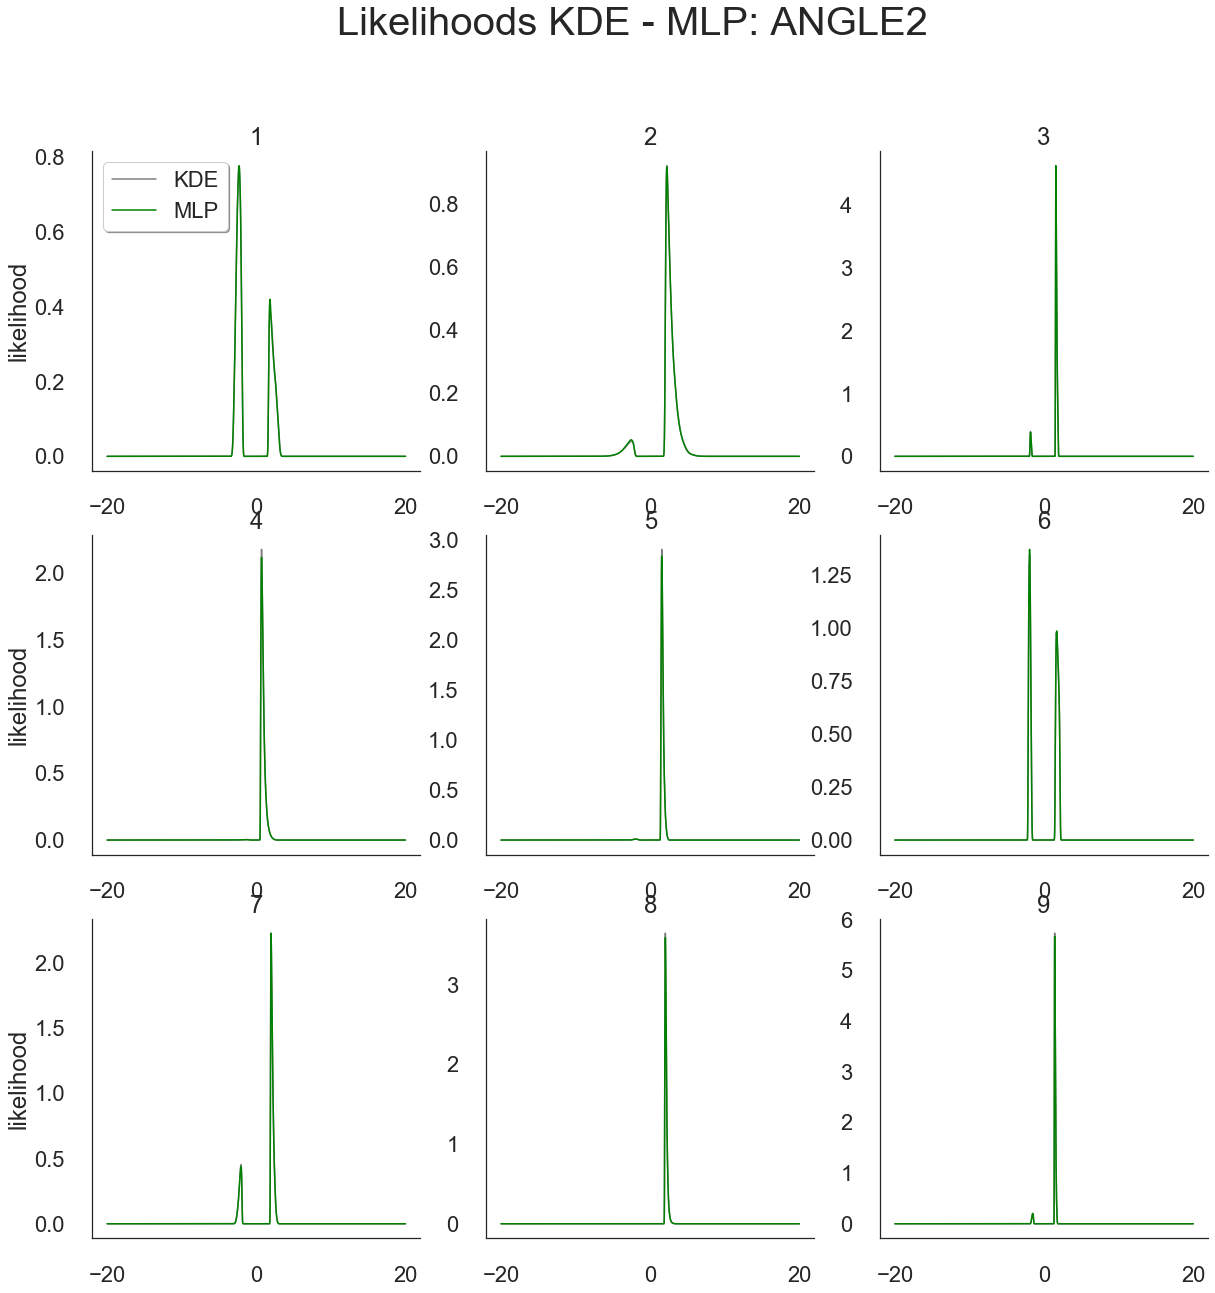

In [141]:
if model == 'angle2':
    model2 = 'angle'
else:
    model2 = model

kde_vs_mlp_likelihoods(ax_titles = [str(i) for i in range(1, n_graphs + 1, 1)],
                       parameter_matrix = parameter_matrix,
                       network_dir = network_path,
                       cols = 3,
                       model = model,
                       n_samples = 20000,
                       nreps = 1,
                       save = True,
                       show = True,
                       machine = 'home',
                       method = 'mlp')

In [140]:
parameter_matrix

array([[-0.91202452,  1.55493815,  0.6858175 ,  1.50132561,  0.66678612],
       [ 0.89192157,  1.27713939,  0.57386887,  1.85941017,  0.11666002],
       [ 1.03768811,  1.1039879 ,  0.70321186,  1.46600091,  1.14565339],
       [ 1.6707823 ,  1.55110885,  0.69259153,  0.46832697,  0.49552855],
       [ 2.33823621,  1.43386609,  0.57459056,  1.28925409,  0.79996045],
       [-0.88471695,  1.64568498,  0.68354756,  1.35063342,  1.07749034],
       [ 0.98149848,  0.72622385,  0.54526278,  1.82673228,  0.42638878],
       [ 2.73590205,  1.32781324,  0.66736968,  1.85784474,  0.52631158],
       [ 2.59968334,  0.71929786,  0.5595439 ,  1.32091567,  0.90341761]])

In [149]:
teststr = 'ddm_weibull_analytic'

In [152]:
test.strip('method')

NameError: name 'test' is not defined